In [20]:
import numpy as np
import scipy.optimize as sopt
import matplotlib.pyplot as plt
import pydae.ssa as ssa
import pydae.grid_tools as gt
from pydae.tools import get_i
import json
import time
import scipy.optimize as sopt
import pandas as pd
from scipy.sparse.linalg import spsolve,spilu,splu
import matplotlib.pyplot as plt
from pydae.svg_tools import svg,grid2svg
from IPython.core.display import HTML


In [21]:
def get_bus_powers(gt_grid,bus_name):
    idx = gt_grid.bus_data['bus_id'].index(bus_name)
    p_a,q_a = gt_grid.buses[idx]['p_a'],gt_grid.buses[idx]['p_a']
    p_b,q_b = gt_grid.buses[idx]['p_b'],gt_grid.buses[idx]['q_b']
    p_c,q_c = gt_grid.buses[idx]['p_c'],gt_grid.buses[idx]['q_c']
    p = p_a + p_b + p_c
    q = q_a + q_b + q_c
    return p,q



In [22]:
from cigre_eu_lv_ind import cigre_eu_lv_ind_class

In [23]:
grid_c0 = cigre_eu_lv_ind_class()

lf = 1.0
          
          
params = {}

#grid_c0.load_0()
t_0 = time.time()
grid_c0.ini(params,'xy_0.json')
print(time.time()-t_0)
grid_c0.report_y()

0.013963937759399414
v_I02_a_r = 195.83
v_I02_a_i = -112.54
v_I02_b_r = -196.00
v_I02_b_i = -113.04
v_I02_c_r = -0.35
v_I02_c_i = 226.65
v_I02_n_r = -0.17
v_I02_n_i =  0.23
v_I01_a_r = 197.95
v_I01_a_i = -115.62
v_I01_b_r = -199.64
v_I01_b_i = -113.27
v_I01_c_r =  1.19
v_I01_c_i = 229.87
v_I01_n_r = -0.17
v_I01_n_i =  0.33
i_t_I00_I01_a_r =  2.51
i_t_I00_I01_a_i = -1.55
i_t_I00_I01_b_r = -2.59
i_t_I00_I01_b_i = -1.39
i_t_I00_I01_c_r =  0.09
i_t_I00_I01_c_i =  2.94
i_load_I02_a_r = -69.88
i_load_I02_a_i = 129.79
i_load_I02_b_r = 147.28
i_load_I02_b_i = -4.48
i_load_I02_c_r = -77.46
i_load_I02_c_i = -125.19
i_load_I02_n_r =  0.06
i_load_I02_n_i = -0.11


In [24]:
grid_c0.save_xy_0('xy_0.json')

In [25]:
grid_c0.fill_factor_ini = 80
grid_c0.drop_tol_ini = 1e-8
grid_c0.drop_rule_ini = 'basic,dynamic,area,prows'
grid_c0.eval_preconditioner_ini()
grid_c0.ltol_ini =1e-8
N = grid_c0.P_slu.shape[0]
Nnz = grid_c0.P_slu.nnz
print(f'{N**2}, {Nnz}, {Nnz/N**2*100}')


961, 546, 56.81581685744017


C:\Users\jmmau\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:407: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [27]:
input_json = 'cigre_eu_lv_ind.json'
output_svg = 'raw_cigre_eu_lv_ind.svg'
grid2svg(input_json,output_svg)
HTML(output_svg)

In [8]:
svg_1 = svg('raw_cigre_eu_lv_com.svg')
   
json_data = open(input_json).read().replace("'",'"')
data = json.loads(json_data)

buses = data['buses']
lines = data['lines']
trafos = data['transformers']

for line in lines:
    #if not 'monitor'in line or not 'vsc_line' in line: continue
    if 'monitor' in line:
        if not line['monitor']: continue
    if 'vsc_line' in line:
        if not line['vsc_line']: continue
    bus_j = line['bus_j']
    bus_k = line['bus_k']

    for ph in ['a','b','c','n']:

        I_max = data["line_codes"][line['code']]['I_max']
        i_r = grid_c0.get_value(f'i_l_{bus_j}_{bus_k}_{ph}_r') 
        i_i = grid_c0.get_value(f'i_l_{bus_j}_{bus_k}_{ph}_i') 
        i = i_r + 1j*i_i
        i_abs = np.abs(i)
        #print(f'l_{bus_j}_{bus_k}_{ph} = {i_abs:8.1f} A')
        if i_abs < 1e-3: continue
        i_sat = np.clip(i_abs**2/I_max**2*255,0,255)
        svg_1.set_color('line',f'l_{bus_j}_{bus_k}_{ph}',(int(i_sat),0,0))
        
        
#svg_1.set_color('rect','R1',(255,9,0))
svg_1.save('cigre_eu_lv_com_i.svg')
HTML('cigre_eu_lv_com_i.svg')

In [26]:
t_0 = time.time()
i_list = []
N = 1000
muls = (0.5-np.random.rand(N))*100e3+70e3
for mul in muls:
    grid_c0.ini({'p_C20_a':mul})
    i_list += [grid_c0.get_value('i_t_C00_C01_a_r')]
print(time.time()-t_0)

2.7965247631073


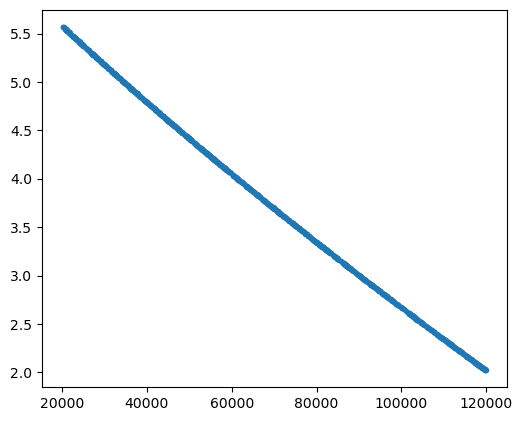

In [27]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 5), dpi=100)
axes.plot(muls,i_list,'.')

In [17]:
i_list

[4.695825789904744,
 4.8512072509082556,
 2.396434769180189,
 2.8645725768870216,
 2.803263168172455,
 5.434429011536248,
 4.4366964036007595,
 4.281595131132943,
 2.769624420681243,
 3.509179057742635,
 3.408529922323668,
 4.267309271568358,
 3.9882873355030934,
 2.674363973023656,
 3.372209573943197,
 2.237731225944638,
 3.232747307125966,
 5.283074617628943,
 5.16573495707839,
 2.8995446681099803,
 4.3913463287586705,
 5.521671099784407,
 3.8268201997252813,
 4.682194970213431,
 3.4793160967193466,
 2.7400237681536495,
 5.258449566467132,
 2.9543755168610777,
 2.320372261870708,
 5.156522664376866,
 2.695392171094685,
 3.068098924156019,
 2.5938914945194167,
 5.388048626904189,
 5.539230527395034,
 3.8505548764899378,
 2.9255571877184687,
 4.356631033127088,
 4.012242025506916,
 3.089977555111294,
 3.7910926283589137,
 2.775366949263019,
 4.296833032844253,
 3.6502370577417067,
 2.7591688858871866,
 5.434288469401673,
 4.507862780831141,
 2.6151107672605414,
 4.451509820150948,
 4.3

In [33]:
json_file = 'cigre_europe_residential_4w2w.json'
json_file = json_file
json_data = open(json_file).read().replace("'",'"')
data = json.loads(json_data)
lines = data['lines']
line_codes = data['line_codes']

In [39]:
svg_1 = svg('cigre.svg')


for line in lines:
    #if not 'monitor'in line or not 'vsc_line' in line: continue
    if 'monitor' in line:
        if not line['monitor']: continue
    if 'vsc_line' in line:
        if not line['vsc_line']: continue
    bus_j = line['bus_j']
    bus_k = line['bus_k']

    for ph in ['a','b','c','n']:

        I_max = data["line_codes"][line['code']]['I_max']
        i_r = grid_c0.get_value(f'i_l_{bus_j}_{bus_k}_{ph}_r') 
        i_i = grid_c0.get_value(f'i_l_{bus_j}_{bus_k}_{ph}_i') 
        i = i_r + 1j*i_i
        i_abs = np.abs(i)
        #print(f'l_{bus_j}_{bus_k}_{ph} = {i_abs:8.1f} A')
        if i_abs < 1e-3: continue
        i_sat = np.clip(i_abs/I_max*255,0,255)
        svg_1.set_color('line',f'l_{bus_j}_{bus_k}_{ph}',(int(i_sat),0,0))
        
        
#svg_1.set_color('rect','R1',(255,9,0))
svg_1.save('test_cigre.svg')
HTML('test_cigre.svg')

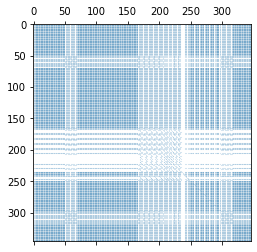

In [137]:
import matplotlib.pyplot as plt
import numpy as np

A = np.abs(grid_c0.P_slu.solve(np.eye(346)))
fig, axs = plt.subplots(1)
axs.spy(A, precision=1e-12, markersize=0.05)


In [53]:
grid_c0f = cigre_europe_residential_4w2w_dbf_class()
t_0 = time.time()
grid_c0f.ini({},'xy_0_dict.json')
print(time.time()-t_0)

0.0359039306640625


200.0

In [95]:
grid_c0f.ini({},'xy_0_dict.json')

grid_c0f.fill_factor_ini=10
grid_c0f.drop_tol_ini=0.001
grid_c0f.drop_rule_ini='interp'  # basic, prows, column, area, secondary, dynamic, interp. 


grid_c0f.lmax_it_ini=20
grid_c0f.ltol_ini=1e-6
grid_c0f.ldamp_ini=1

grid_c0f.eval_preconditioner_ini()




In [96]:
#%%timeit
t_0 = time.time()
p_R10 = np.random.rand()*10e3
grid_c0f.spini({'p_R10':p_R10},'xy_0_dict.json')
print(time.time()-t_0)
#print(grid_c0f.get_value('v_R10_a_r'))

0.01595759391784668


In [88]:
t_0 = time.time()
grid_c0f.ini({},'xy_0_dict.json')
print(time.time()-t_0)

0.05385541915893555


In [66]:
grid_c0f.mode = 0

In [21]:
%%timeit 
p_R10 = np.random.rand()*10e3
grid_c0f.ini({'p_R10':p_R10},'xy_0_dict.json')

44.6 ms ± 7.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
grid_c0.P_slu.shape

(346, 346)

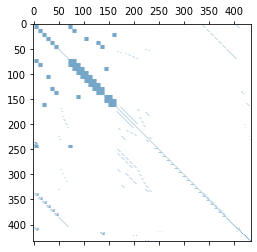

In [69]:
A = grid_c0f.jac_ini
fig, axs = plt.subplots(1)
axs.spy(A, precision=1e-8, markersize=0.05)


In [70]:
434*434

188356

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Fixing random state for reproducibility
np.random.seed(19680801)

fig, axs = plt.subplots(2, 2)
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

x = np.random.randn(20, 20)
x[5, :] = 0.
x[:, 12] = 0.

ax1.spy(x, markersize=5)
ax2.spy(x, precision=0.1, markersize=5)

ax3.spy(x)
ax4.spy(x, precision=0.1)

plt.show()

In [ ]:
plt.imshow(A[0:10,0:10], cmap='hot')
plt.show()

In [ ]:
A = grid_c0f.P_slu.solve(np.eye(434))
plt.imshow(np.abs(A), cmap='hot')
plt.show()

In [ ]:
self = grid_c0f
self.sp_jac_ini.data[self.sp_jac_ini.data==0]

In [7]:
p_R1 = 200e3
for ph in ['a','b','c']:
    grid_c0.set_value(f'p_R1_{ph}', -p_R1/3)
grid_c0.ss()

v_R18_a_r = grid_c0.get_value('v_R18_a_r')
v_R18_a_i = grid_c0.get_value('v_R18_a_i')
v_R18_a = v_R18_a_r + 1j*v_R18_a_i

In [138]:
def get_bus_powers(gt_grid,bus_name):
    idx = gt_grid.bus_data['bus_id'].index(bus_name)
    p_a,q_a = gt_grid.buses[idx]['p_a'],gt_grid.buses[idx]['p_a']
    p_b,q_b = gt_grid.buses[idx]['p_b'],gt_grid.buses[idx]['q_b']
    p_c,q_c = gt_grid.buses[idx]['p_c'],gt_grid.buses[idx]['q_c']
    p = p_a + p_b + p_c
    q = q_a + q_b + q_c
    return p,q

def vsc2params(vsc_losses,name,multiplier=1):
    i_rms  = np.array(vsc_losses[name]['i_rms'])
    p_loss = np.array(vsc_losses[name]['p_loss']) 
    c,b,a = np.polyfit(i_rms, p_loss*multiplier,2)
    return a,b,c

def report(grid, gt_grid):
    p_R0,q_R0 = get_bus_powers(gt_grid,'R0')
    p_R1,q_R1 = get_bus_powers(gt_grid,'R1')
    p_D1,q_D1 = get_bus_powers(gt_grid,'D1')
    p_R10,q_R10 = get_bus_powers(gt_grid,'R10')
    p_D10,q_D10 = get_bus_powers(gt_grid,'D10')
    p_R14,q_R14 = get_bus_powers(gt_grid,'R14')
    p_D14,q_D14 = get_bus_powers(gt_grid,'D14')

    p_R1_load = (loads_ac[0]['kVA']*np.exp(1j*np.arccos( loads_ac[0]['pf']))*1000).real

    p_main_vsc_ac = -(p_R1 - p_R1_load)

    p_dc_losses = p_main_vsc_ac - grid.p_dc_loads

    p_losses = p_R0 + grid.p_ac_loads + grid.p_dc_loads
    grid.p_losses = p_losses
    print(f'Grid power = {p_R0/1e3:0.2f} kW')
    print(f'AC loads   = {-grid.p_ac_loads/1e3:0.2f} kW')
    print(f'DC loads   = {-grid.p_dc_loads/1e3:0.2f} kW')
    print(f'Total load = {-(grid.p_ac_loads+grid.p_dc_loads)/1e3:0.2f} kW')
    p_loss_R1  = -(p_R1+p_D1-p_R1_load)
    p_loss_R10 = -(p_R10+p_D10)
    p_loss_R14 = -(p_R14+p_D14)
    print(f'VSC Losses: R1 = {p_loss_R1:0.2f} W ({-p_loss_R1/p_R1*100:0.1f}%),  R10 = {p_loss_R10:0.2f} W ({p_loss_R10/p_R10*100:0.1f}%),  R14 = {p_loss_R14:0.2f} W ({p_loss_R14/p_R14*100:0.1f}%)')

    idx = [(item['bus_j'],item['bus_k']) for item in gt_grid.lines].index(('R1', 'R2'))
    i_j_a_m = gt_grid.lines[idx]['i_j_a_m']
    print(f'Current R1-R2 ={i_j_a_m:0.2f} A')
    idx = [(item['bus_j'],item['bus_k']) for item in gt_grid.lines].index(('R4', 'R12'))
    i_j_a_m = gt_grid.lines[idx]['i_j_a_m']
    print(f'Current R4-R12 ={i_j_a_m:0.2f} A')
    idx = [(item['bus_j'],item['bus_k']) for item in gt_grid.lines].index(('D1', 'D3'))
    i_j_a_m = gt_grid.lines[idx]['i_j_a_m']
    print(f'Current D1-D3 ={i_j_a_m:0.2f} A')
    idx = [(item['bus_j'],item['bus_k']) for item in gt_grid.lines].index(('D4', 'D14'))
    i_j_a_m = gt_grid.lines[idx]['i_j_a_m']
    print(f'Current D4-R14 ={i_j_a_m:0.2f} A')


### VSC models

In [139]:
vsc_losses = {
    'vsc_3ph3w_200A_100kVA':{'model':'','coolant':'air','v_dc':800,
                            'i_rms':[50,100,200],'p_loss':[404.9,871.61,2090.05],'rend':[98.6,98.54,98.26]},
    'vsc_3ph3w_250A_200kVA':{'model':'SKiiP1213GB123-2DW V3','coolant':'water','Rth_sa': 0.0114,'v_dc':800,
                            'i_rms':[125,250,500],'p_loss':[1210.95,2610.23,6229.22],'rend':[98.38,98.26,97.93]}, 
    'vsc_1ph2w_120A':{'model':'SKiiP39AC12T7V1_HpTp','coolant':'air','v_dc':800,'pf':0.85,'Rth_sa': 0.0707,
                         'i_rms':[20,40,60,80,100,120],
                         'p_loss':[96.91,205.54,322.16,455.22,609.84,795.07],
                         'rend':[97.59,97.45,97.34,97.18,96.99,96.74]}
}



## Case 0

In [140]:
loads_ac =[{"bus":  "R1", "kVA":-200.0, "pf": 0.95},
           {"bus": "R11", "kVA": -15.0, "pf": 0.95},
           {"bus": "R15", "kVA": -52.0, "pf": 0.95},
           {"bus": "R16", "kVA": -55.0, "pf": 0.95},
           {"bus": "R17", "kVA": -35.0, "pf": 0.95},
           {"bus": "R18", "kVA": -47.0, "pf": 0.95}]

loads_dc =[{"bus": "D11", "kW": 0.0},
           {"bus": "D15", "kW": 0.0},
           {"bus": "D16", "kW": 0.0},
           {"bus": "D17", "kW": 0.0},
           {"bus": "D18", "kW": 0.0}]

vscs =[{"bus": "R1", "type":'vdc',"kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_200A_100kVA')},
       {"bus": "R10","type":'pq', "kW":10.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_200A_100kVA')},
       {"bus": "R14","type":'pq', "kW":10.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_200A_100kVA')}
      ]

In [141]:
grid_c0 = cigre_europe_residential_4w2w_class()

grid_c0.p_ac_loads = 0.0
for load in loads_ac:
    bus_name = load['bus']
    s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
    gt.set_powers(grid_c0,bus_name,s)
    grid_c0.p_ac_loads += s.real

grid_c0.p_dc_loads = 0.0
for load in loads_dc:
    bus_name = load['bus']
    grid_c0.set_value(f'p_{bus_name}_1',load['kW']*1000.0)
    grid_c0.set_value(f'q_{bus_name}_1',0.0)
       
for vsc in vscs:
    bus_name = vsc['bus']
    if vsc['bus'] == 'pq':
        s = vsc['kW'] + 1j*vsc['kvar']
        grid_c0.set_value(f'p_{bus_name}',vsc['kW']*1000.0)
        grid_c0.set_value(f'q_{bus_name}',vsc['kvar']*1000.0)
    grid_c0.set_value(f'a_{bus_name}',vsc['losses'][0])
    grid_c0.set_value(f'b_{bus_name}',vsc['losses'][1])
    grid_c0.set_value(f'c_{bus_name}',vsc['losses'][2])
    

import json 

def save_params(self,file_name = 'case_0_parameters.json'):
    params_dict = {}
    for item in self.params_list:
        params_dict.update({item:self.get_value(item)})

    params_dict_str = json.dumps(params_dict, indent=4)
    with open(file_name,'w') as fobj:
        fobj.write(params_dict_str)

def save_inputs_ini(self,file_name = 'case_0_inputs_ini.json'):
    inputs_ini_dict = {}
    for item in self.inputs_ini_list:
        inputs_ini_dict.update({item:self.get_value(item)})

    inputs_ini_dict_str = json.dumps(inputs_ini_dict, indent=4)
    with open(file_name,'w') as fobj:
        fobj.write(inputs_ini_dict_str)
              
def load_inputs_ini(self,data_input):

    if type(data_input) == str:
        json_file = data_input
        self.json_file = json_file
        self.json_data = open(json_file).read().replace("'",'"')
        data = json.loads(self.json_data)
    elif type(data_input) == dict:
        data = data_input

    for item in data:
        self.struct[0][item] = data[item]
        self.inputs_ini_values_list[self.inputs_ini_list.index(item)] = data[item]
        self.set_value(item,data[item])
            
            
save_params(grid_c0)
save_inputs_ini(grid_c0)


In [143]:
grid_c0.load_params('case_0_parameters.json')
grid_c0.load_params('case_0_inputs_ini.json')
grid_c0.ini({},'xy_0_dict.json')
gt_grid = gt.grid(grid_c0)

AttributeError: 'cigre_europe_residential_4w2w_class' object has no attribute 'struct'

In [59]:
gt_grid = gt.grid(grid_c0)
gt_grid.dae2vi()

gt_grid.get_v()
gt_grid.get_i()

gt_grid.bokeh_tools()

gt.plot_results(gt_grid)

Figure(id='1003', ...)

In [14]:
def s_eval(grid,bus_j,bus_k):
    line_id = f'{bus_j}_{bus_k}'
    i_t_r = np.array(grid.get_mvalue([f'i_t_{line_id}_a_r',f'i_t_{line_id}_b_r',f'i_t_{line_id}_c_r']))
    i_t_i = np.array(grid.get_mvalue([f'i_t_{line_id}_a_i',f'i_t_{line_id}_b_i',f'i_t_{line_id}_c_i']))
    i_t = i_t_r + 1j*i_t_i
    v_r = np.array(grid.get_mvalue([f'v_{bus_j}_a_r',f'v_{bus_j}_b_r',f'v_{bus_j}_c_r']))
    v_i = np.array(grid.get_mvalue([f'v_{bus_j}_a_i',f'v_{bus_j}_b_i',f'v_{bus_j}_c_i']))
    v = v_r + 1j*v_i
    
    s = v.T @ np.conj(i_t)
    return s


In [15]:
grid = grid_c0
grid.initialization_tol = 1e-8
def obj_eval(x):

    grid.set_values({'p_R10':x[0],'q_R10':x[1]})
    grid.set_values({'p_R14':x[2],'q_R14':x[3]})
    grid.ss()
    s_t = s_eval(grid,'R0','R1')
    p_head = float(s_t.real)
    #print(f'p_loss = {p_loss/1e3:0.2f}')

    return p_head



In [16]:
sol = sopt.minimize(obj_eval,[10e3]*4,method='Powell',bounds=[(-50e3,50e3)]*4) # SLSQP, Powell
sol

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-1.05619837e+03, -4.40626705e+02,  3.10373770e+02,
         9.30591158e+01]])
     fun: array(394154.46549016)
 message: 'Optimization terminated successfully.'
    nfev: 282
     nit: 3
  status: 0
 success: True
       x: array([40719.61622939, 29828.3615968 , 35709.0174598 , 18348.42156993])

In [17]:
def contraint_I_R1_R2(x):
    grid.set_values({'p_R10':x[0],'q_R10':x[1]})
    grid.set_values({'p_R14':x[2],'q_R14':x[3]})
    grid.ss()
    I_R1_R2 = np.abs(grid_c0.get_value('i_l_R1_R2_a_r')+1j*grid_c0.get_value('i_l_R1_R2_a_i'))
    return I_R1_R2

def contraint_I_VSC_R1(x):
    grid.set_values({'p_R10':x[0],'q_R10':x[1]})
    grid.set_values({'p_R14':x[2],'q_R14':x[3]})
    grid.ss()
    I_VSC_R1 = np.abs(grid_c0.get_value('i_vsc_R1_a_r')+1j*grid_c0.get_value('i_vsc_R1_a_i'))
    return I_VSC_R1

def contraint_I_VSC_R10(x):
    grid.set_values({'p_R10':x[0],'q_R10':x[1]})
    grid.set_values({'p_R14':x[2],'q_R14':x[3]})
    grid.ss()
    I_VSC_R10 = np.abs(grid_c0.get_value('i_vsc_R10_a_r')+1j*grid_c0.get_value('i_vsc_R10_a_i'))
    return I_VSC_R10

def contraint_I_VSC_R14(x):
    grid.set_values({'p_R10':x[0],'q_R10':x[1]})
    grid.set_values({'p_R14':x[2],'q_R14':x[3]})
    grid.ss()
    I_VSC_R14 = np.abs(grid_c0.get_value('i_vsc_R14_a_r')+1j*grid_c0.get_value('i_vsc_R14_a_i'))
    return I_VSC_R14


nlcs = (
    NonlinearConstraint(contraint_I_R1_R2, -np.inf, 160),
    NonlinearConstraint(contraint_I_VSC_R1, -np.inf, 160),
    NonlinearConstraint(contraint_I_VSC_R10, -np.inf, 20),
    NonlinearConstraint(contraint_I_VSC_R14, -np.inf, 30),
    
)

sopt.differential_evolution(obj_eval, bounds=[(-50e3,50e3)]*4,constraints=(nlcs), tol=1e-10)

NameError: name 'NonlinearConstraint' is not defined

In [ ]:
           constr: [array([0.])]
 constr_violation: 0.0
              fun: 394250.2397244236
            maxcv: 0.0
          message: 'Optimization terminated successfully.'
             nfev: 5090
              nit: 162
          success: True
                x: array([48825.59389023, 32058.74316143, 40651.51398465, 19213.75435129])

In [109]:
I_VSC_R1 = np.abs(grid_c0.get_value('i_vsc_R1_a_r')+1j*grid_c0.get_value('i_vsc_R1_a_i'))
I_VSC_R1

128.84763241935278

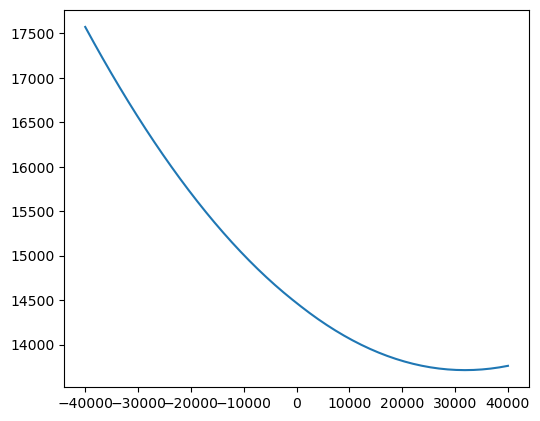

In [65]:
p_loss_1 = []
p_loss_2 = []
qs_1 = np.linspace(-40e3,40e3)
for q in qs_1:
    p_loss_1 += [obj_eval(np.array([0,0,0,q]))]
    p_loss_2 += [obj_eval(np.array([40e3,q,40e3,0]))]
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 5), dpi=100)

axes.plot(qs_1,p_loss_1)
#axes.plot(qs_1,p_loss_2)

In [117]:
gt_grid = gt.grid(grid)
gt_grid.dae2vi()

gt_grid.get_v()
gt_grid.get_i()

gt_grid.bokeh_tools()

gt.plot_results(gt_grid)

Figure(id='2803', ...)

## Case 1

In [9]:
scale = 1.5
loads_ac =[{"bus":  "R1", "kVA":-200.0, "pf": 0.95},
           {"bus": "R11", "kVA": -15.0*scale, "pf": 0.95},
           {"bus": "R15", "kVA": -52.0*scale, "pf": 0.95},
           {"bus": "R16", "kVA": -55.0*scale, "pf": 0.95},
           {"bus": "R17", "kVA": -35.0*scale, "pf": 0.95},
           {"bus": "R18", "kVA": -47.0*scale, "pf": 0.95}]

loads_dc =[{"bus": "D11", "kW": 0.0},
           {"bus": "D15", "kW": 0.0},
           {"bus": "D16", "kW": 0.0},
           {"bus": "D17", "kW": 0.0},
           {"bus": "D18", "kW": 0.0}]

vscs =[{"bus":  "R10", "kW":0.0, "kvar": 0.0},
        {"bus": "R14", "kW":0.0, "kvar": 0.0}]

In [10]:
grid_c1 = cigre_europe_residential_acdc_class()
grid_c1.initialization_tol = 1e-8

for load in loads_ac:
    bus_name = load['bus']
    s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
    gt.set_powers(grid_c1,bus_name,s)

for load in loads_dc:
    bus_name = load['bus']
    grid_c1.set_value(f'p_{bus_name}_1',load['kW']*1000.0)
    grid_c1.set_value(f'q_{bus_name}_1',0.0)
    
for vsc in vscs:
    bus_name = load['bus']
    s = vsc['kW'] + 1j*vsc['kvar']
    grid_c1.set_value(f'p_{bus_name}',vsc['kW']*1000.0)
    grid_c1.set_value(f'q_{bus_name}',vsc['kvar']*1000.0)


grid_c1.initialize([{}],xy0='xy_0_dict.json',compile=True)
gt_grid = gt.grid(grid_c1)


NameError: name 'cigre_europe_residential_acdc_class' is not defined

In [106]:
gt_grid.dae2vi()

vsc_buses = ['R1','R10','R14']
a2n = {'a':1,'b':2,'c':3}
for vsc_bus in vsc_buses:
    for ph in ['a','b','c']:
        idx = list(gt_grid.nodes_list).index(f'{vsc_bus}.{a2n[ph]}') 
        gt_grid.I_node[idx] += grid_c1.get_value(f'i_vsc_{vsc_bus}_{ph}_r')+1j*grid_c1.get_value(f'i_vsc_{vsc_bus}_{ph}_i')

gt_grid.get_v()
gt_grid.get_i()

gt_grid.bokeh_tools()

gt.plot_results(gt_grid)

NameError: name 'grid_c1' is not defined

## Case 2

In [96]:
scale_ac = 1.0
scale_dc = 0.5

loads_ac =[{"bus":  "R1", "kVA":-00.0, "pf": 0.95},
           {"bus": "R11", "kVA": -15.0*scale_ac, "pf": 0.95},
           {"bus": "R15", "kVA": -52.0*scale_ac, "pf": 0.95},
           {"bus": "R16", "kVA": -55.0*scale_ac, "pf": 0.95},
           {"bus": "R17", "kVA": -35.0*scale_ac, "pf": 0.95},
           {"bus": "R18", "kVA": -47.0*scale_ac, "pf": 0.95}]

loads_dc =[{"bus": "D11", "kW": -15.0*scale_dc},
           {"bus": "D15", "kW": -52.0*scale_dc},
           {"bus": "D16", "kW": -55.0*scale_dc},
           {"bus": "D17", "kW": -35.0*scale_dc},
           {"bus": "D18", "kW": -47.0*scale_dc}]

vscs =[{"bus": "R1", "type":'vdc',"kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_250A_200kVA')},
       {"bus": "R10","type":'pq', "kW":10.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_250A_200kVA')},
       {"bus": "R14","type":'pq', "kW":10.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_250A_200kVA')}
      ]


In [97]:
grid_c2 = cigre_europe_residential_4w2w_class()
grid_c2.initialization_tol = 1e-8

grid_c2.p_ac_loads = 0.0
for load in loads_ac:
    bus_name = load['bus']
    s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
    gt.set_powers(grid_c2,bus_name,s)
    grid_c2.p_ac_loads += s.real

grid_c2.p_dc_loads = 0.0
for load in loads_dc:
    bus_name = load['bus']
    grid_c2.set_value(f'p_{bus_name}_1',load['kW']*1000.0)
    grid_c2.set_value(f'q_{bus_name}_1',0.0)
    grid_c2.p_dc_loads += load['kW']*1000.0
    
for vsc in vscs:
    bus_name = vsc['bus']
    if vsc['bus'] == 'pq':
        s = vsc['kW'] + 1j*vsc['kvar']
        grid_c2.set_value(f'p_{bus_name}',vsc['kW']*1000.0)
        grid_c2.set_value(f'q_{bus_name}',vsc['kvar']*1000.0)
    grid_c2.set_value(f'a_{bus_name}',vsc['losses'][0])
    grid_c2.set_value(f'b_{bus_name}',vsc['losses'][1])
    grid_c2.set_value(f'c_{bus_name}',vsc['losses'][2])
    
grid_c2.initialize([{}],xy0='xy_0_dict.json',compile=True)
gt_grid_c2 = gt.grid(grid_c2)


In [98]:
gt_grid_c2.dae2vi()

vsc_buses = ['R1','R10','R14']
a2n = {'a':1,'b':2,'c':3}
for vsc_bus in vsc_buses:
    for ph in ['a','b','c']:
        idx = list(gt_grid_c2.nodes_list).index(f'{vsc_bus}.{a2n[ph]}') 
        I_r = grid_c2.get_value(f'i_vsc_{vsc_bus}_{ph}_r')
        I_i = grid_c2.get_value(f'i_vsc_{vsc_bus}_{ph}_i')
        gt_grid_c2.I_node[idx] += I_r+1j*I_i

gt_grid_c2.get_v()
gt_grid_c2.get_i()

gt_grid_c2.bokeh_tools()

gt.plot_results(gt_grid_c2)



Figure(id='1863', ...)

In [99]:
report(grid_c2, gt_grid_c2)

Grid power = 311.44 kW
AC loads   = 193.80 kW
DC loads   = 102.00 kW
Total load = 295.80 kW
VSC Losses: R1 = 106404.72 W (50.7%),  R10 = 87.65 W (665137773198266271525010581409567854297088.0%),  R14 = 87.65 W (2461545763729826353443264930983662265040896.0%)
Current R1-R2 =317.52 A
Current R4-R12 =81.94 A
Current D1-D3 =129.19 A
Current D4-R14 =32.92 A


In [100]:
grid_c2.report_params()

a_R1  = 85.15
b_R1  =  7.91
c_R1  =  0.01
a_R10 = 85.15
b_R10 =  7.91
c_R10 =  0.01
coef_a_R10 =  0.33
coef_b_R10 =  0.33
coef_c_R10 =  0.33
a_R14 = 85.15
b_R14 =  7.91
c_R14 =  0.01
coef_a_R14 =  0.33
coef_b_R14 =  0.33
coef_c_R14 =  0.33


## Case 3

In [8]:
scale_ac = 0.1
scale_dc = 1.0

loads_ac =[{"bus":  "R1", "kVA":-200.0, "pf": 0.95},
           {"bus": "R11", "kVA": -15.0*scale_ac, "pf": 0.95},
           {"bus": "R15", "kVA": -52.0*scale_ac, "pf": 0.95},
           {"bus": "R16", "kVA": -55.0*scale_ac, "pf": 0.95},
           {"bus": "R17", "kVA": -35.0*scale_ac, "pf": 0.95},
           {"bus": "R18", "kVA": -47.0*scale_ac, "pf": 0.95}]

loads_dc =[{"bus": "D11", "kW": -15.0*scale_dc},
           {"bus": "D15", "kW": -52.0*scale_dc},
           {"bus": "D16", "kW": -55.0*scale_dc},
           {"bus": "D17", "kW": -35.0*scale_dc},
           {"bus": "D18", "kW": -47.0*scale_dc}]

vscs =[{"bus": "R1", "type":'vdc',"kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_250A_200kVA',multiplier=1)},
       {"bus": "R10","type":'pq', "kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_1ph2w_120A')},
       {"bus": "R14","type":'pq', "kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_1ph2w_120A')}
      ]


In [9]:
grid_c3 = cigre_europe_residential_2w2w_class()
grid_c3.initialization_tol = 1e-12

grid_c3.p_ac_loads = 0.0
for load in loads_ac:
    bus_name = load['bus']
    if bus_name == 'R1':
        s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
        gt.set_powers(grid_c3,bus_name,s)
        grid_c3.p_ac_loads += s.real
    if bus_name != 'R1':
        s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
        grid_c3.set_value(f'p_{bus_name}_a',s.real)
        grid_c3.set_value(f'p_{bus_name}_b',0.0)
        grid_c3.set_value(f'p_{bus_name}_c',0.0)
        grid_c3.set_value(f'q_{bus_name}_a',s.imag)
        grid_c3.set_value(f'q_{bus_name}_b',0.0)
        grid_c3.set_value(f'q_{bus_name}_c',0.0)
        grid_c3.p_ac_loads += s.real
    
grid_c3.p_dc_loads = 0.0
for load in loads_dc:
    bus_name = load['bus']
    grid_c3.set_value(f'p_{bus_name}_1',load['kW']*1000.0)
    grid_c3.set_value(f'q_{bus_name}_1',0.0)
    grid_c3.p_dc_loads += load['kW']*1000.0
    
for vsc in vscs:
    bus_name = vsc['bus']
    if vsc['bus'] == 'pq':
        s = vsc['kW'] + 1j*vsc['kvar']
        grid_c3.set_value(f'p_{bus_name}',vsc['kW']*1000.0)
        grid_c3.set_value(f'q_{bus_name}',vsc['kvar']*1000.0)
    grid_c3.set_value(f'a_{bus_name}',vsc['losses'][0])
    grid_c3.set_value(f'b_{bus_name}',vsc['losses'][1])
    grid_c3.set_value(f'c_{bus_name}',vsc['losses'][2])

solx = np.array([ 31725.12992576,  37213.72959454,  31933.80290348, -36446.6370987 ])
solx = np.array([28421.96223811, 15531.3515862 , 23105.72335649,  9431.03994459])
#grid_c3.initialize([{'p_R10':solx[0],'q_R10':solx[1],'coef_a_R10':1.0,'coef_b_R10':0.0,'coef_c_R10':0.0,
#                     'p_R14':solx[2],'q_R14':solx[3],'coef_a_R14':1.0,'coef_b_R14':0.0,'coef_c_R14':0.0}],
#                     xy0='xy_0_dict.json',compile=True)
grid_c3.load_0('xy_0_dict.json')
grid_c3.ss()

In [10]:
gt_grid_c3 = gt.grid(grid_c3)

gt_grid_c3.dae2vi()

gt_grid_c3.get_v()
gt_grid_c3.get_i()

gt_grid_c3.bokeh_tools()

gt.plot_results(gt_grid_c3)

Figure(id='1145', ...)

In [11]:
grid = grid_c3
grid.initialization_tol = 1e-8
def obj_eval(x):
    p_R10 = x[0]
    q_R10 = x[1]
    p_R14 = x[2]
    q_R14 = x[3]
    #
    grid.set_value('p_R10', p_R10)
    grid.set_value('p_R14', p_R14)
    grid.set_value('q_R10', q_R10)
    grid.set_value('q_R14', q_R14)
    
    grid.ss()

    bus_from,bus_to = 'R0','R1'
    i_t_r_list = []
    i_t_i_list = []
    for ph in ['a','b','c']:
        i_t_r_list += [f'i_t_{bus_from}_{bus_to}_{ph}_r']
        i_t_i_list += [f'i_t_{bus_from}_{bus_to}_{ph}_i']
    i_t = np.array(grid.get_mvalue(i_t_r_list)) +1j*np.array(grid.get_mvalue(i_t_i_list))

    v_t = gt.get_voltage(grid,bus_from,output='v_abcn')

    s_t = v_t.T @ np.conj(i_t).reshape(3,1)
    p_loss = float(s_t.real+grid_c3.p_ac_loads+grid_c3.p_dc_loads)
    #print(f'p_loss = {p_loss/1e3:0.2f}')

    return p_loss


In [26]:
sol = sopt.minimize(obj_eval,[10e3]*4,method='Powell',bounds=[(-50e3,50e3)]*4) # SLSQP, Powell
sol

   direc: array([[   0.        ,    0.        ,    0.        ,    1.        ],
       [   0.        ,    1.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    1.        ,    0.        ],
       [-297.41706976,  -31.8052777 ,   57.16811962,   10.44169443]])
     fun: array(25377.29323184)
 message: 'Optimization terminated successfully.'
    nfev: 262
     nit: 3
  status: 0
 success: True
       x: array([28421.94957707, 15531.61331538, 23105.72994969,  9430.9358909 ])

In [27]:
gt_grid_c3 = gt.grid(grid_c3)

gt_grid_c3.dae2vi()

vsc_buses = ['R1','R10','R14']
a2n = {'a':1,'b':2,'c':3}
for vsc_bus in vsc_buses:
    for ph in ['a','b','c']:
        idx = list(gt_grid_c3.nodes_list).index(f'{vsc_bus}.{a2n[ph]}') 
        gt_grid_c3.I_node[idx] += grid_c3.get_value(f'i_vsc_{vsc_bus}_{ph}_r')+1j*grid_c3.get_value(f'i_vsc_{vsc_bus}_{ph}_i')

gt_grid_c3.get_v()
gt_grid_c3.get_i()

gt_grid_c3.bokeh_tools()

gt.plot_results(gt_grid_c3)

Figure(id='1145', ...)

In [82]:
def ini_problem(self,x):
    self.struct[0].x[:,0] = x[0:self.N_x]
    self.struct[0].y_ini[:,0] = x[self.N_x:(self.N_x+self.N_y)]
    if self.compile:
       # ini(self.struct,2)
        ini(self.struct,3)       
    else:
        ini.py_func(self.struct,2)
        ini.py_func(self.struct,3)                   
    fg = np.vstack((self.struct[0].f,self.struct[0].g))[:,0]
    return fg

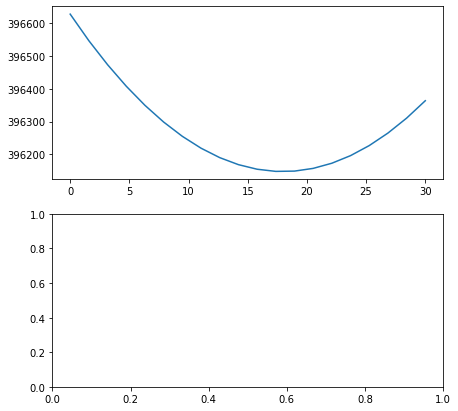

In [55]:
fig,  axes   = plt.subplots(nrows=2,ncols=1, figsize=(7, 7))
axes[0].plot(p_dc/1e3,p_loss)

In [17]:
sol

   direc: array([[   0.        ,    1.        ],
       [-935.21979958,  339.14541993]])
     fun: array(12282.76966481)
 message: 'Optimization terminated successfully.'
    nfev: 116
     nit: 3
  status: 0
 success: True
       x: array([20871.11509636, 23407.62236097])

In [21]:
gt_grid.dae2vi()

vsc_buses = ['R1','R10','R14']
a2n = {'a':1,'b':2,'c':3}
for vsc_bus in vsc_buses:
    for ph in ['a','b','c']:
        idx = list(gt_grid.nodes_list).index(f'{vsc_bus}.{a2n[ph]}') 
        gt_grid.I_node[idx] += grid.get_value(f'i_vsc_{vsc_bus}_{ph}_r')+1j*grid.get_value(f'i_vsc_{vsc_bus}_{ph}_i')

gt_grid.get_v()
gt_grid.get_i()

gt_grid.bokeh_tools()

gt.plot_results(gt_grid)

Figure(id='1145', ...)

In [39]:
from importlib import reload  



In [40]:
reload(ini)

TypeError: reload() argument must be a module

In [31]:
ini(grid_c3.struct,1)

In [148]:
@numba.njit(cache=True)
def ssate(struct,xy):
    for it in range(100):
        ini_dae_jacobian_numba(struct,xy[:,0])
        ini_dae_problem(struct,xy[:,0])
        xy[:] += np.linalg.solve(struct[0].Ac_ini,-struct[0].fg)
        if np.max(np.abs(struct[0].fg[:,0]))<1e-8: break
    N_x = struct[0].N_x
    struct[0].x[:,0] = xy[:N_x,0]
    struct[0].y_ini[:,0] = xy[N_x:,0]
    return xy,it

In [6]:
305.5-212.5

93.0

In [1]:
from scipy.optimize import rosen, differential_evolution
bounds = [(0,2), (0, 2), (0, 2), (0, 2), (0, 2)]


In [8]:
%timeit result = differential_evolution(rosen, bounds)
result.x, result.fun

3.38 s ± 318 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NameError: name 'result' is not defined

In [7]:
%timeit result = differential_evolution(rosen, bounds, updating='deferred', workers=2)
result.x, result.fun

6.26 s ± 950 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NameError: name 'result' is not defined

In [9]:
from multiprocessing import Process
import os

def info(title):
    print(title)
    print('module name:', __name__)
    print('parent process:', os.getppid())
    print('process id:', os.getpid())

def f(name):
    info('function f')
    print('hello', name)

if __name__ == '__main__':
    info('main line')
    p = Process(target=f, args=('bob',))
    p.start()
    p.join()

main line
module name: __main__
parent process: 5780
process id: 6040


In [3]:
import multiprocessing as mp
import time 
from scipy.optimize import rosen, differential_evolution

rosen_1 = rosen
rosen_2 = rosen
pool = mp.Pool(4)  # existing worker pool

bounds = [(0,2), (0, 2), (0, 2), (0, 2), (0, 2)]

t_0 = time.time()
result = differential_evolution(rosen, bounds, updating='deferred', workers=pool.map)
print(time.time() - t_0)
result

6.6938416957855225


     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 48006
     nit: 639
 success: True
       x: array([1., 1., 1., 1., 1.])

In [4]:
rosen_1 = rosen
rosen_2 = rosen
pool.Map([rosen_1,rosen_2])

AttributeError: 'Pool' object has no attribute 'Map'